In [3]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import os
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback

In [5]:
images_1 = np.load('data/Fold 1/images/fold1/images.npy').astype(np.uint8) 
masks_1 = np.load('data/Fold 1/masks/fold1/masks.npy').astype(np.uint8) 
#images_2 = np.load('data/Fold 2/images/fold2/images.npy',mmap_mode='r').astype(np.uint8) 
#masks_2 = np.load('data/Fold 2/masks/fold2/masks.npy').astype(np.uint8) 
#images_3 = np.load('data/Fold 3/images/fold3/images.npy',mmap_mode='r').astype(np.uint8) 
#masks_3 = np.load('data/Fold 3/masks/fold3/masks.npy').astype(np.uint8) 
types_1 = np.load('data/Fold 1/images/fold1/types.npy')
#types_2 = np.load('data/Fold 2/images/fold2/types.npy')
#types_3 = np.load('data/Fold 3/images/fold3/types.npy')
print("shape images:", images_1.shape)
print("types images:", types_1.shape)
print("masks images:", masks_1.shape)


shape images: (2656, 256, 256, 3)
types images: (2656,)
masks images: (2656, 256, 256, 6)


In [6]:
types_1 = np.load('data/Fold 1/images/fold1/types.npy')
#types_2 = np.load('data/Fold 2/images/fold2/types.npy')
#types_3 = np.load('data/Fold 3/images/fold3/types.npy')

In [4]:
print("shape images:", images_1.shape)
print("types images:", types_1.shape)
print("masks images:", masks_1.shape)

NameError: name 'images_1' is not defined

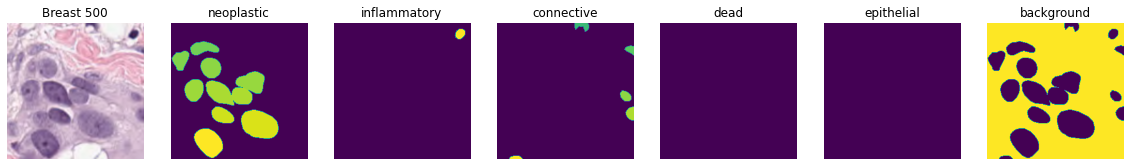

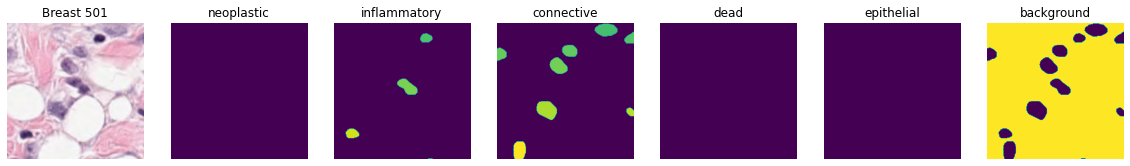

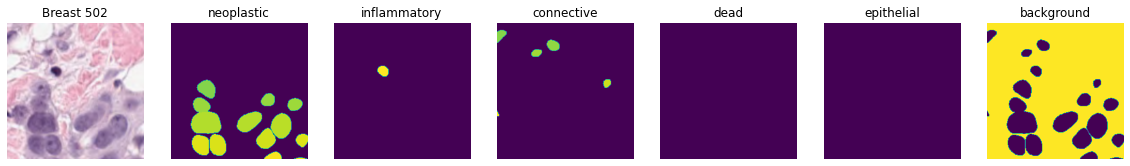

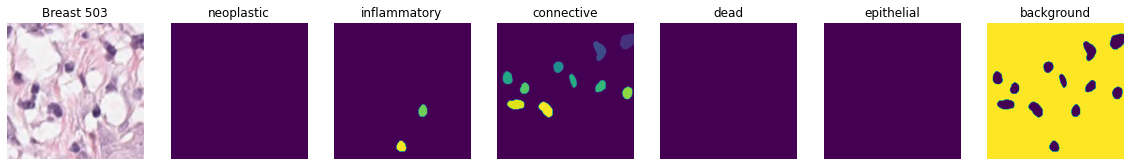

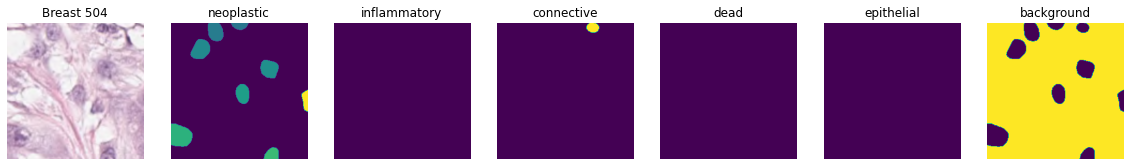

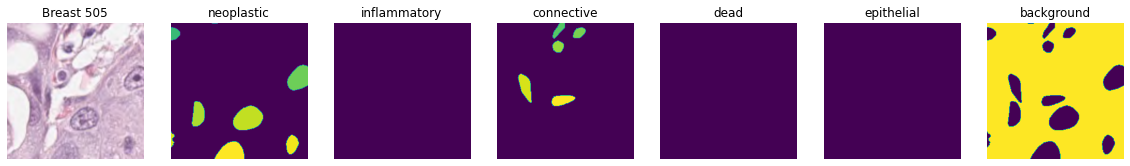

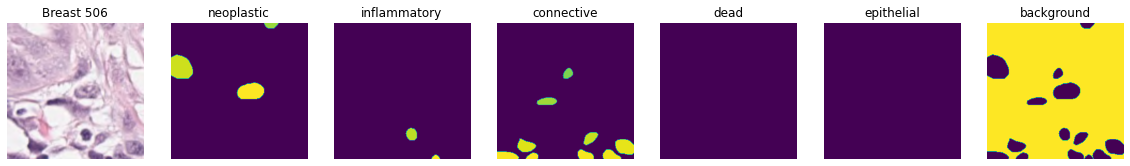

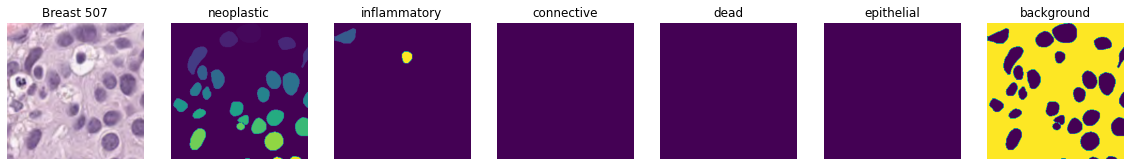

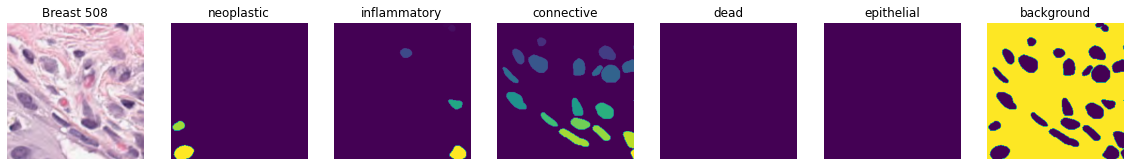

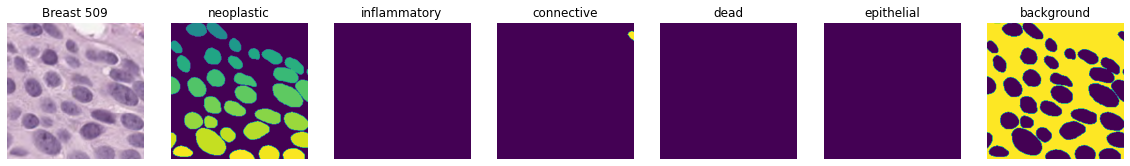

In [9]:
maskNames = ["neoplastic", "inflammatory", "connective", "dead", "epithelial", "background"]
def plot_images_mask(i, images, masks, figsize = (20,10)):
    global maskNames
    global types_1
    plt.figure(figsize=figsize)
    plt.subplot(171)
    plt.imshow(images[i])
    plt.title(types_1[i] + " " + str(i))
    plt.axis("off")
    
    for j in range(6):
        plt.subplot(172+j)
        plt.imshow(masks[i,:,:,j])
        plt.title(maskNames[j])
        plt.axis("off")
        
    plt.show()

for i in range(500, 510):
    plot_images_mask(i, images_1, masks_1)



In [7]:
#converting the inputs to 0 and 1 with 0 the background and 1 is the nuclei
x = images_1
y = masks_1[:,:,:,5]
y = np.where((y==0)|(y==1), y^1, y) # convert 0 to 1; 1 to 0
    #masks0[i,:,:]=(masks0[i,:,:] - np.min(masks0[i,:,:]))/(np.max(masks0[i,:,:])-np.min(masks0[i,:,:]))
    

In [8]:


# Number of images
no_img = y.shape[0]
print("Number of images : %d \t " % (no_img))

# Compute width and height of images
img_ht = x.shape[1]
img_wd = y.shape[2]
print("Image size: %dx%d" % (img_wd, img_ht))

y = y.reshape(no_img, img_ht, img_ht, 1)
print(y.shape)



Number of images : 2656 	 
Image size: 256x256
(2656, 256, 256, 1)


In [13]:
counts = collections.Counter(types_1)
print(counts)

Counter({'Breast': 827, 'Colon': 478, 'Bile-duct': 159, 'Esophagus': 155, 'Cervix': 155, 'Adrenal_gland': 134, 'Lung': 80, 'Thyroid': 80, 'Pancreatic': 78, 'Prostate': 77, 'HeadNeck': 70, 'Liver': 65, 'Testis': 60, 'Skin': 59, 'Ovarian': 54, 'Stomach': 50, 'Kidney': 37, 'Bladder': 21, 'Uterus': 17})


[1, 2, 3, 4, 5]
[6]


In [9]:


train_percentage=0.7
n_train = int(train_percentage*no_img)
x_train = x[0:100]
x_val   = x[2600:]
y_train = y[0:100]
y_val   = y[2600:]
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)



(100, 256, 256, 3)
(56, 256, 256, 3)
(100, 256, 256, 1)
(56, 256, 256, 1)


In [10]:


# Metric function to check the similarities between two samples 
#(i.e true and predicted images)
#the dice coefficient formula is 2 * overlapped area / sum of pixels in true and predicted images
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)



In [11]:
from tensorflow.keras.optimizers import Adam
#Used UNet architecture for which c is convolution layer, d is dropout, 
#p is pooling layer, u for transpose
def u_net(img_wd=256,img_ht=256,channel=3):
    inputs = Input((img_ht, img_wd, channel))
    norm = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (norm)
    d1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    d2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    d3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    d4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    d5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    d6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    d7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    d8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    d9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (d9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    opt = Adam(lr=0.0008)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=[dice_coef])
    model.summary()
    return model

In [30]:
# To set model Parameters
#Used basic parameters and only ran the model for 5 epochs
from tensorflow.keras import models
model = u_net()

history1 = model.fit(x_train, 
          y_train, 
          steps_per_epoch = n_train//32, 
          batch_size = 32,
          epochs =5, 
          shuffle=True, 
          initial_epoch=0, 
          validation_data = (x_val, y_val))

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
_______________________________________________________________________________________

In [31]:


# History of accuracy and loss
tra_loss1 = history1.history['loss']
tra_dice_coef = history1.history['dice_coef']
val_loss1 = history1.history['val_loss']
val_dice_coef = history1.history['val_dice_coef']

# Total number of epochs training
epochs1 = range(1, len(tra_dice_coef)+1)
end_epoch1 = len(tra_dice_coef)

# Epoch when reached the validation loss minimum
opt_epoch1 = val_loss1.index(min(val_loss1)) + 1

# Loss and accuracy on the validation set
opt_val_loss1 = val_loss1[opt_epoch1-1]
opt_val_dice_coef = val_dice_coef[opt_epoch1-1]
print("Model 1\n")
print("Epoch [opt]: %d" % opt_epoch1)
print("Valid dice coef [opt]: %.4f" % opt_val_dice_coef)
# print("Test dice coef [opt]:  %.4f" % opt_test_dice_coef)
print("Valid loss [opt]: %.4f" % opt_val_loss1)
# print("Test loss [opt]:  %.4f" % opt_test_loss1)



Model 1

Epoch [opt]: 1
Valid dice coef [opt]: 0.3802
Valid loss [opt]: 0.3416


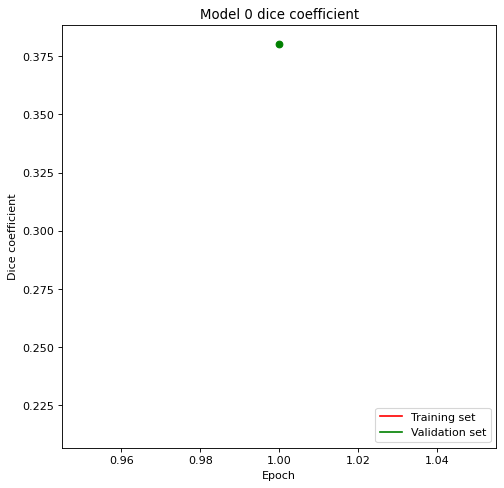

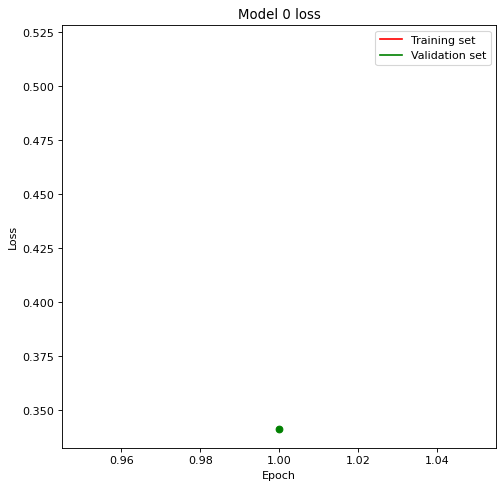

In [32]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 dice coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('Epoch')
plt.plot(epochs1, tra_dice_coef, 'r', label='Training set')
plt.plot(epochs1, val_dice_coef, 'g', label='Validation set')
plt.plot(opt_epoch1, val_dice_coef[opt_epoch1-1], 'go')
plt.vlines(opt_epoch1, min(val_dice_coef), opt_val_dice_coef, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_dice_coef, 1, opt_epoch1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs1, tra_loss1, 'r', label='Training set')
plt.plot(epochs1, val_loss1, 'g', label='Validation set')
plt.plot(opt_epoch1, val_loss1[opt_epoch1-1], 'go')
plt.vlines(opt_epoch1, min(val_loss1), opt_val_loss1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss1, 1, opt_epoch1, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [16]:


# Set number of GPUs
num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (256,256) 

In [33]:
import os
import datetime
import glob
import random
import sys

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

import numpy as np
import pandas as pd
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.layers import LeakyReLU


from tensorflow.keras.layers import add, concatenate
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from tensorflow.keras import backend as K
import tensorflow as tf

#import tensorflow.keras.preprocessing.image.ImageDataGenerator
import sklearn
from sklearn.model_selection import train_test_split


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
Numpy        : 1.18.5
Skimage      : 0.14.2
Scikit-learn : 0.23.2
Tensorflow   : 2.3.1


In [33]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3

In [15]:
preds_val = model.predict(x_val, verbose=1)
# Threshold predictions
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5)

2/2 [==============================] - 1s 630ms/step


In [16]:
preds_val.shape

(56, 256, 256, 1)

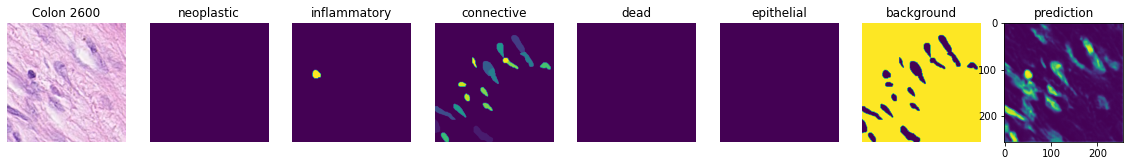

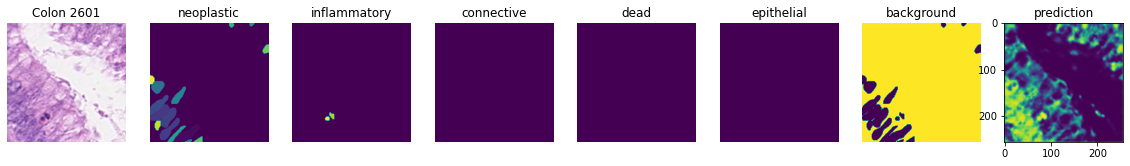

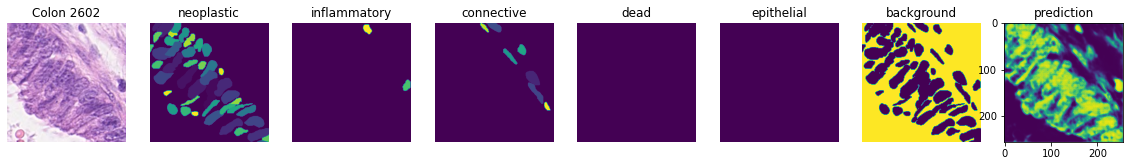

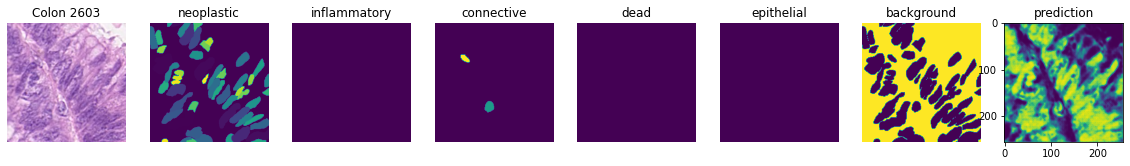

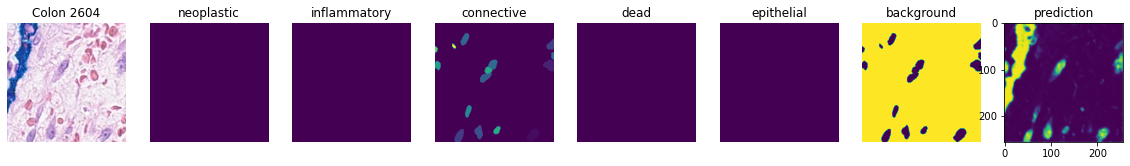

In [29]:
maskNames = ["neoplastic", "inflammatory", "connective", "dead", "epithelial", "background"]
def plot_images_mask(i, images, masks, figsize = (20,10)):
    global maskNames
    global types_1
    plt.figure(figsize=figsize)
    plt.subplot(181)
    plt.imshow(images[i])
    plt.title(types_1[i] + " " + str(i))
    plt.axis("off")
    
    for j in range(6):
        plt.subplot(182+j)
        plt.imshow(masks[i,:,:,j])
        plt.title(maskNames[j])
        plt.axis("off")
    plt.subplot(188)
    plt.imshow(preds_val[i-2600,:,:,:])
    plt.title('prediction')
    plt.show()

for i in range(2600, 2605):
    plot_images_mask(i, images_1, masks_1)
#fig,ax=plt.subplots(6,3)
#for i in range(6):
 #   ax[i][0].imshow(x_val[i,:,:,:3])
  #  ax[i][1].imshow(masks_1[2600+i,:,:,0])
   # ax[i][2].imshow(preds_val[i,:,:,:])
    #ax[i][0].set_title(types_1[2600+i])
#plt.tight_layout()

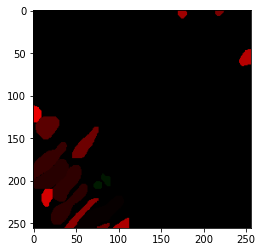

In [20]:
plt.imshow(masks_1[2601,:,:,:3])

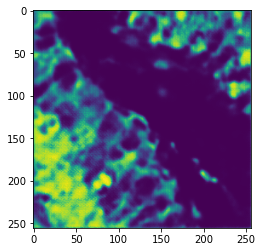

In [21]:
plt.imshow(preds_val[1,:,:,:])

In [61]:
(preds_val[0,:,:,:]>0.5).astype('uint8')

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [87]:
#dice_coef(np.squeeze(y_val[pos]), np.squeeze(preds_val_t[pos]))
#dice_coef(y_val,preds_val)
y_true_f = K.flatten(y_val[0,:,:,:])
y_pred_f = K.flatten((preds_val[0,:,:,:]>0.5).astype('uint8'))
#y_true_f
intersection=K.sum(y_true_f*y_pred_f)
K.sum(y_true_f) + K.sum(y_pred_f)
#intersection = K.sum(y_true_f * y_pred_f)
tf.print(2*intersection  / (K.sum(y_true_f) + K.sum(y_pred_f) ))

#dice_coef(y_val[0,:,:,:],(preds_val[0,:,:,:]>0.5).astype('float'))

<tf.Operation 'PrintV2' type=PrintV2>

TypeError: Input 'y' of 'Mul' Op has type bool that does not match type uint8 of argument 'x'.

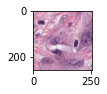

In [38]:
plt.figure(figsize=(20,16))
x, y = 16,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(x_val[pos])
        plt.title('Image #{}\nIOU {}'.format(pos,round(dice_coef(np.squeeze(y_val[pos]), np.squeeze(preds_val_t[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(y_val[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_val_t[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()